# Linear Regression for House Prices

Based on the [UFLDL tutorial](http://ufldl.stanford.edu/tutorial/supervised/LinearRegression) with a few key changes:

 - Matrix operations are used on the whole dataset (as a single batch given it is small), rather than loops on individual items.
 - Single training example x-values are row rather than column vectors (i.e. we use $y = x w^T + b$ not $y = w^T x + b$).

In [175]:
from os import path
from requests import get
from pandas import read_fwf
from torch import tensor
import torch
from unittest import TestCase, TextTestRunner, TestLoader
from matplotlib import pyplot

## Data

Note that the convention used in this tutorial is to represent training examples as colums, whereas in Pytorch the convention is e.g. `nn.Linear` is to use [training examples as rows](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) which seems more intuative. For this work I'll adopt the PyTorch convention, so that for a single training example the x-values are assumed to be a row vector and the weights are also a row vector.

In [99]:
local_path = path.join("data", "housing.data")

# Download the data if it doesn't exist localy
if not path.isfile(local_path):
    # Use a github-based source for convenience of downloading (the tutorial data link no longer exists)
    housing_data_url = "https://raw.githubusercontent.com/ehlemur/UFLDL/master/housing.data"
    r = get(housing_data_url, allow_redirects=True)
    open(local_path, 'wb').write(r.content)

# Get the data from the file, and show a smaple
df = read_fwf(local_path, header=None)
df.rename(columns={13 : "Price"}).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,Price
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


As the columns are quite different, we will want to normalize each column:

In [191]:
raw_data = tensor(df.values, dtype=torch.float)
rows_mean = raw_data.mean(0)
rows_std = raw_data.std(0)
normalized = (raw_data - rows_mean ) / rows_std
normalized[:,-1] = raw_data[:,-1] # Put the price back in so the charts make sense
normalized[0,:] # View the first row

tensor([-0.6444,  0.2845, -1.2866, -0.2723, -0.1441,  0.4133, -0.1199,  0.1969,
        -2.3512, -0.6659, -1.4576,  0.4406, -1.0745, 24.0000])

Converting to tensors:

In [186]:
train_x = normalized[:400,0:-1]
train_y = normalized[:400,-1].unsqueeze(1) # Make vertical vector
test_x = normalized[401:,0:-1]
test_y = normalized[401:,-1].unsqueeze(1)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

(torch.Size([400, 13]),
 torch.Size([400, 1]),
 torch.Size([105, 13]),
 torch.Size([105, 1]))

## Model

### Hypothesis

$
h(x^i) = \sum_j x^i_j w_j + b
$

For a batch:

$
h(X) = X w^T + b
\\
X \in \mathbb{R}^{m \times n}, w \in \mathbb{R}^{1 \times n}, b \in \mathbb{R}
\\
m = \text{number of items in the batch}
$

In [4]:
def weighted_sum_inputs(inputs: tensor, weights: tensor, bias: float) -> tensor:
    """
    Return the elementwise multiplication plus a bias
    
    Parameters
    ==========
    inputs: mxn matrix, where m is the number of items in a batch and n is the number of values in each item's input
    weights: 1xn vector of weights (note must be 2 dimensional)
    bias: float bias
    
    Returns
    =======
    Column vector of predictions (1xm tensor)
    """
    # Check the shapes (to avoid common errors)
    assert(inputs.dim() > 1)
    assert(weights.dim() > 1)
    
    # Return the weighted sum of inputs
    weights_transposed = torch.transpose(weights, 0, -1)
    return torch.matmul(inputs, weights_transposed) + bias

class TestWeightedSumInputs(TestCase):
    def test_batch(self):
        inputs = tensor(
            [[1.,2,3],
             [1,2,5]]
        )
        weights = tensor([[2.,2,2]])
        bias = 1.
        res = weighted_sum_inputs(inputs, weights, bias)
        expected = tensor([[13.],[17.]])
        self.assertTrue(torch.all(torch.eq(res,expected)))

suite = TestLoader().loadTestsFromTestCase(TestWeightedSumInputs)
TextTestRunner(verbosity=4).run(suite)

test_batch (__main__.TestWeightedSumInputs) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

### Loss

For loss we use the half mean squared error across all training items:

$
\displaystyle
J(w) = \frac{1}{2 n} \sum_i (h(x^i)-y^i)^2
\\
y \in \mathbb{R}^{n \times 1}
\\
n = \text{number of samples}
$

In [5]:
def half_mean_squared_error(predictions: tensor, targets: tensor) -> float:
    """
    Returns the half mean squared error of a batch
    
    Parameters
    ==========
    predictions: column vector of predictions
    targets: column vector of targets
    
    Returns
    ======
    Batch loss (float)
    """
    squared_errors = (predictions - targets) ** 2
    sum_squared_errors = torch.sum(squared_errors).item()
    number_predictions = predictions.shape[0]
    return sum_squared_errors / (2 * number_predictions )

class TestHalfSumSquaredErrors(TestCase):
    def test_batch(self):
        predictions = tensor([[1.],[1]])
        targets = tensor([[3.],[3]])
        expected = 2.0
        res = half_mean_squared_error(predictions, targets)
        self.assertEqual(res, expected)

suite = TestLoader().loadTestsFromTestCase(TestHalfSumSquaredErrors)
TextTestRunner(verbosity=4).run(suite)

test_batch (__main__.TestHalfSumSquaredErrors) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

### Back Propogation

For a specific $w_j$ the partial derivaive of loss is:

$
\displaystyle
\frac{\partial J}{\partial w_j} = \frac{1}{n} \sum_i(x_j^i \times (h(x^i) - y^i))
$

Using matrix operators on the batch:

$
v = \text{errors} = h(X) - y ;  v \in \mathbb{R}^{n \times 1}
\\
\displaystyle
\nabla_w J = \frac{1}{n} v^T X
\\
\nabla_w \in \mathbb{R}^{1 \times n}
$

In [77]:
def gradient_loss_with_respect_to_weights(inputs: tensor, predictions: tensor, targets: tensor) -> tensor:
    """
    Returns the partial derivative of loss with respect to all weights (as a row vector)
    """
    errors = predictions - targets
    errors_transposed = errors.T
    number_predictions = predictions.shape[0]
    return torch.matmul(errors_transposed, inputs) / number_predictions

class TestGradientLossWithRespectToWeights(TestCase):
    def test_batch(self):
        inputs = tensor([
            [1., 1],
            [2., 4]
        ])
        predictions = tensor([
            [1.],
            [2]
        ])
        targets = tensor([
            [2.],
            [3.]
        ])
        res = gradient_loss_with_respect_to_weights(inputs, predictions, targets)
        expected = tensor([[-1.5, -2.5]])
        self.assertTrue(torch.all(torch.eq(res,expected)))

suite = TestLoader().loadTestsFromTestCase(TestGradientLossWithRespectToWeights)
TextTestRunner(verbosity=4).run(suite)

test_batch (__main__.TestGradientLossWithRespectToWeights) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

For the bias, the partial derivative of loss is:

$
\displaystyle
\frac{\partial J}{\partial b} = \frac{1}{n} \sum_i(h(x^i) - y^i))
$

In [48]:
def partial_derivative_loss_with_respect_to_bias(predictions: tensor, targets: tensor) -> float:
    errors = predictions - targets
    sum_errors = torch.sum(errors)
    number_predictions = predictions.shape[0]
    return sum_errors.item() / number_predictions

class TestPartialDerivativeLossWithRespectToBias(TestCase):
    def test_batch(self):
        predictions = tensor([
            [1.],
            [2]
        ])
        targets = tensor([
            [2.],
            [3.]
        ])
        res = partial_derivative_loss_with_respect_to_bias(predictions, targets)
        expected = (1. - 2 + 2 - 3)/2
        self.assertEqual(res, expected)

suite = TestLoader().loadTestsFromTestCase(TestPartialDerivativeLossWithRespectToBias)
TextTestRunner(verbosity=4).run(suite)

test_batch (__main__.TestPartialDerivativeLossWithRespectToBias) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

### Step

We step the weights (row vector) and bias (float) by the learning rate multiplied by the respective partial derivatives:

$
w_{t+1} = w_t - \nabla_w J * l_r
\\
b_{t+1} = b_t - \frac{\partial J}{\partial b} * l_r
\\
l_r \in \mathbb{R}
$

These steps are done inline in the sgd function, for simplicity.

## Putting it all together (SGD)

After initialising the random weights & bias, we loop through epochs that:

 1. Calculate the hypothesis result
 2. Calculate the loss
 3. Calculate the partial derivatives
 4. Step the weights and bias

In [187]:
def sgd(inputs: tensor, targets: tensor, epochs: int, learning_rate: float) -> (tensor, float):
    # Initialise random weights and bias
    weights = torch.rand(1, inputs.shape[1], dtype=torch.float)
    bias = torch.rand(1).item()
    
    for i in range(epochs):
    
        predictions = weighted_sum_inputs(inputs, weights, bias)

        loss = half_mean_squared_error(predictions, targets)

        partial_d_weights = gradient_loss_with_respect_to_weights(inputs, predictions, targets)
        partial_d_bias = partial_derivative_loss_with_respect_to_bias(predictions, targets)
        
        # step
        weights -= partial_d_weights * learning_rate
        bias -= partial_d_bias * learning_rate
        
        if i == 0 or ((i + 1) % 100) == 0:
            print("Epoch: ", i + 1 , "loss: ", loss)
    
    return weights, bias
    
trained_weights, trained_bias = sgd(train_x, train_y, 1000,.01)

Epoch:  1 loss:  384.4596875
Epoch:  100 loss:  47.5880078125
Epoch:  200 loss:  20.77211669921875
Epoch:  300 loss:  15.47825927734375
Epoch:  400 loss:  13.999190673828124
Epoch:  500 loss:  13.435069580078125
Epoch:  600 loss:  13.150001220703125
Epoch:  700 loss:  12.97358154296875
Epoch:  800 loss:  12.851387939453126
Epoch:  900 loss:  12.76211669921875
Epoch:  1000 loss:  12.695303955078124


## Test the model

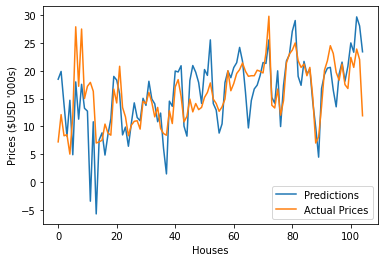

Signature: pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)
Docstring:
Plot y versus x as lines and/or markers.

Call signatures::

    plot([x], y, [fmt], *, data=None, **kwargs)
    plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)

The coordinates of the points or line nodes are given by *x*, *y*.

The optional parameter *fmt* is a convenient way for defining basic
formatting like color, marker and linestyle. It's a shortcut string
notation described in the *Notes* section below.

>>> plot(x, y)        # plot x and y using default line style and color
>>> plot(x, y, 'bo')  # plot x and y using blue circle markers
>>> plot(y)           # plot y using x as index array 0..N-1
>>> plot(y, 'r+')     # ditto, but with red plusses

You can use `.Line2D` properties as keyword arguments for more
control on the appearance. Line properties and *fmt* can be mixed.
The following two calls yield identical results:

>>> plot(x, y, 'go--', linewidth=2, markersize=12)
>>> plot(x,

In [202]:
predictions = weighted_sum_inputs(test_x, trained_weights, trained_bias)
pyplot.plot(predictions, label="Predictions")
pyplot.plot(test_y, label="Actual Prices")
pyplot.ylabel("Prices ($USD '000s)")
pyplot.xlabel("Houses")
pyplot.legend()
plt.show()
pyplot.plot??

Looks pretty accurate!